In [1]:
from scipy import integrate
import sympy as sp
import numpy as np
from numpy import linalg as la 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
matplotlib.rcParams['animation.embed_limit'] = 2**128
from IPython.display import HTML
font = {'size'   : 15}
matplotlib.rc('font', **font)
from RKSchemes import ImEx_schemes
from Homogenized_system_coefficients import C_values
from Homogenized_system_coefficients import Homogenized_system_coef
fft = np.fft.fft
ifft = np.fft.ifft

In [2]:
a = lambda y: np.sin(2*np.pi*y)+5
dady= lambda y: 2*np.pi*np.cos(2*np.pi*y)
delta = 0.001
C1, C2, C3, C4, C5, C6, C7, C8, avga,ainvavg = C_values(a=a,dady=dady,delta=delta)

In [3]:
gamma = 1.4 
kappa =1
p_0 = 1
P1 = gamma*kappa*p_0**(gamma-1)
P11= (gamma-1)*gamma*kappa*p_0**(gamma-2)
r1,r2,r3,r4,r5,r6,k1,k2,k3,k4,k5,k6,k7=Homogenized_system_coef(C1,C2,C3,C4,C5,C6,C7,C8,avga,ainvavg,p_0,P1,P11,delta)

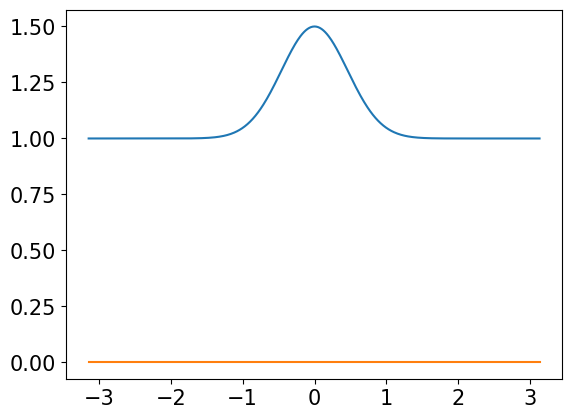

In [4]:
L = 2*np.pi; m = 512
x = np.arange(-m/2,m/2)*(L/m)
xi = np.fft.fftfreq(m)*m*2*np.pi/L
A = 0.5
rho0 = p_0 + A*np.exp(-2.36*(x)**2)
q0 = np.zeros_like(rho0)
u0 = np.zeros(2*m)
u0[:m] = rho0; u0[m:] = q0

In [6]:
def rhs_linear(u,xi):
    #Evaluate the linear term
    m = len(xi)
    rho = u[:m]; q = u[m:];
    v = np.zeros_like(u)
    rhohat = np.real(ifft(1j*xi*fft(rho)))
    qhat = np.real(ifft(1j*xi*fft(q)))
    rhs_rho = (1/avga)*(-qhat + r6*np.real(ifft((1j*xi)**3 *fft(q))))
    rhs_q = k1*rhohat
    v[:m] = rhs_rho; v[m:] = rhs_q;
    return v

In [7]:
def rhs_nonlinear(u, xi):
    #Evaluate the nonlinear term
    m = len(xi)
    rho = u[:m]; q = u[m:];
    v = np.zeros_like(u)
    rhox_f = np.real(ifft(1j*xi*fft(rho))); rh0xx_f = np.real(ifft((1j*xi)**2 *fft(rho)));
    qx_f = np.real(ifft(1j*xi*fft(q))); qxx_f = np.real(ifft((1j*xi)**2 *fft(q)));
    rhohat = fft(rho); qhat = fft(q)
    rhs_rho = (1/avga)*( r1*q*rhox_f + r2*q**2*qx_f + r3*q*rh0xx_f  + \
                       r4*rhox_f*qx_f + r5*rho*q*rhox_f ) + 1.e-16
    rhs_q = k2*q*qx_f + k3*rho*q*qx_f + (k4*q**2 + k5*rho)*rhox_f + k6*qx_f**2 + k7*q*qxx_f + 1.e-16
    v[:m] = rhs_rho; v[m:] = rhs_q;
    return v